# Column Generation

 
## Bin packing problem

### First formulation

We have to put items of size I in bins of size L. We want to minimize the number of bins used.

Decision variables:
 - $y_j$: 1 if bin j is used
 - $x_{ij}$: 1 if item i is placed in bin j

$
\min \sum y_j\\
s.t.\\
\sum_j x_{ij} = 1 \forall i (1)\\
\sum_i L_i * x_ij \le L * y_j \forall j (2) \\
x_ij \le y_j (3) \\
$

Constraints:
 - (1) ensure that item i is put i a bin
 - (2) ensure that the capacity of bin is not exceeded
 - (3) ensure that, if one item is put in a bin, the bin is considered as used
 
### Second formulation

We express the problem as find a set of patterns (a way of filling a bin).
We have a list I containing all unique sizes of items.
The list Q is equal to the number of unique sizes items to put.  

Decision variables:
 - $x_p$: equals to the number of times a pattern is used

$
\min \sum x_p\\
s.t.\\
\sum_p M_{ip} x_p \ge Q_i\forall i \in I(1)\\
$

M_ip is the number of items of size Q_i that can be store in pattern p.

There is an exponential number of patterns. The idea is to start with a small set of pattern and only add a pattern (a column) if needed


## Column Generation

1. Start with a small set of paths/patterns/column
2. Solve LP
3. Check if solution can be improved by adding a new pattern
 - Yes : Add pattern/column and got to step 2
 - No : Optimal solution found
 
To know which pattern to add, we need to find a new column with **maximum reduced cost**.

Given $\lambda_i$, the primal variable. We need to solve the following **pricing problem**:

$
\max \sum \lambda_i y_i\\
s.t.\\
\sum L_i * y_i \le L
$

We will have $M_{ip} = y_i$ for the new pattern p.

The solution can be improved if reduce cost  of the new pattern is negative, i.e.:

$
\sigma_j = c - \sum_i M_{ip} \lambda_i \le 0 \Rightarrow c \le \sum_i M_{ip} \lambda_i
$

In the bin packing problem, c = 1

$
1 \le \sum_i M_{ip} \lambda_i
$

Which is the termination condition of the column generation algorithm

In [1]:
import pyomo.environ as pyo
import numpy as np

duals = []
primal_objectives = []

L = 9
I = [2,3,4,5,6,7,8] # Unique size of items
Q = [4,2,6,6,2,2,2] # Requested quantity of items
dim_P = len(I)
M = np.eye(dim_P)

solver = pyo.SolverFactory("cbc")

## Master Restricted Problem & Pricing problem

In [2]:
while True:
    # Solve Master Restricted Problem
    mrp = pyo.ConcreteModel()
    mrp.I = pyo.RangeSet(0, len(I) - 1)
    mrp.P = pyo.RangeSet(0, dim_P - 1)
    mrp.x = pyo.Var(mrp.P, within = pyo.NonNegativeReals) # We relax the domain of x
    mrp.o = pyo.Objective(rule=sum([mrp.x[p] for p in mrp.P]))
    mrp.c = pyo.Constraint(mrp.I, expr=lambda m, i: sum([M[i, p] * mrp.x[p] for p in mrp.P]) >= Q[i])
    mrp.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    solver.solve(mrp)
    
    # Dual variables / Shadow price
    lambdas = [mrp.dual[mrp.c[i]] for i in mrp.I]
    
    primal_objectives.append(pyo.value(mrp.o))
    duals.append(lambdas)
    
    # Solve Pricing Problem
    pricing = pyo.ConcreteModel()
    pricing.I = pyo.RangeSet(0, len(I) - 1)
    pricing.y = pyo.Var(pricing.I, within=pyo.NonNegativeIntegers)
    pricing.o = pyo.Objective(rule=sum([lambdas[i] * pricing.y[i] for i in pricing.I]), sense = pyo.maximize)
    pricing.c = pyo.Constraint(rule=sum([I[i] * pricing.y[i] for i in pricing.I]) <= L)
    # Can be solve with integer knapsack algorithm
    solver.solve(pricing)
    
    # Ensure that the reduce costs are negative
    if pyo.value(pricing.o) <= 1:
        break
    
    # Add new path / Variable to Master Restricted Problem
    M = np.hstack((M,np.array([[pyo.value(pricing.y[i])] for i in pricing.I])))
    dim_P = M.shape[1]

In [3]:
# Reintegrate integer constraints and solve MRP
for p in mrp.P:
    mrp.x[p].domain = pyo.NonNegativeIntegers
solver.solve(mrp)

print(f"Number of bins = {pyo.value(mrp.o)}")

for p in mrp.P:
    nb_of_pattern = pyo.value(mrp.x[p])
    if nb_of_pattern > 0:
        pattern = list(zip(M[:, p], I))
        print(f"Pattern {p} - {pattern} requested {nb_of_pattern} times")

Number of bins = 13.0
Pattern 6 - [(0.0, 2), (0.0, 3), (0.0, 4), (0.0, 5), (0.0, 6), (0.0, 7), (1.0, 8)] requested 2.0 times
Pattern 9 - [(0.0, 2), (0.0, 3), (2.0, 4), (0.0, 5), (0.0, 6), (0.0, 7), (0.0, 8)] requested 1.0 times
Pattern 10 - [(0.0, 2), (0.0, 3), (1.0, 4), (1.0, 5), (0.0, 6), (0.0, 7), (0.0, 8)] requested 5.0 times
Pattern 11 - [(2.0, 2), (0.0, 3), (0.0, 4), (1.0, 5), (0.0, 6), (0.0, 7), (0.0, 8)] requested 1.0 times
Pattern 12 - [(0.0, 2), (1.0, 3), (0.0, 4), (0.0, 5), (1.0, 6), (0.0, 7), (0.0, 8)] requested 2.0 times
Pattern 14 - [(1.0, 2), (0.0, 3), (0.0, 4), (0.0, 5), (0.0, 6), (1.0, 7), (0.0, 8)] requested 2.0 times


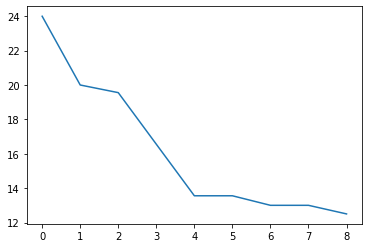

In [4]:
import matplotlib.pyplot as plt

plt.plot(primal_objectives)

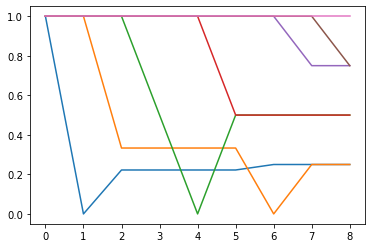

In [5]:
a = plt.plot(duals)

In [6]:
mrp.c.pprint()

c : Size=7, Index=I, Active=True
    Key : Lower : Body                                        : Upper : Active
      0 :   4.0 : x[0] + 3.0*x[7] + 2.0*x[11] + x[13] + x[14] :  +Inf :   True
      1 :   2.0 :              x[1] + x[7] + 3.0*x[8] + x[12] :  +Inf :   True
      2 :   6.0 :                     x[2] + 2.0*x[9] + x[10] :  +Inf :   True
      3 :   6.0 :                        x[3] + x[10] + x[11] :  +Inf :   True
      4 :   2.0 :                        x[4] + x[12] + x[13] :  +Inf :   True
      5 :   2.0 :                                x[5] + x[14] :  +Inf :   True
      6 :   2.0 :                                        x[6] :  +Inf :   True
